# **Market-1501 Person Re-ID with PyTorch**
**“Person Re-Identification on Market-1501 using ResNet50 Embeddings”**


---

## 🔹 **Pipeline Overview**

1. **Dataset Preparation**

   * Load **Market-1501** dataset (`bounding_box_train`, `query`, `bounding_box_test`).
   * Parse each filename into **person ID (pid)** and **camera ID (camid)**.
   * For evaluation, we keep raw pid/camid (no remapping).

2. **Model**

   * Backbone: **ResNet50** pretrained on ImageNet.
   * Remove the classifier; use the last global pooled feature (2048-D).
   * Apply **L2 normalization** → features are unit vectors, so similarity = cosine similarity.

3. **Feature Extraction**

   * Pass **gallery** and **query** images through the model.
   * Store feature vectors + their pids, camids, and paths.

4. **Evaluation**

   * For each query:

     * Compute cosine similarity with all gallery features.
     * Exclude **same pid & same camera** images (junk).
     * Rank gallery by similarity.
     * Compute:

       * **Rank-1 accuracy** (probability top-1 match is correct).
       * **mAP (mean Average Precision)** (quality of entire ranked list).
   * Aggregate results across queries.

5. **Visualization**

   * Pick a few query images.
   * Show the **query + Top-K retrieved gallery images**.
   * Mark retrieved images as **green (correct pid)** or **red (wrong pid)**.

---


Device: cuda


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 211MB/s]


Model ready.
Gallery images: 15913
Query images:   3368
Extracting gallery features...
Extracting query features...
Feature shapes: torch.Size([15913, 2048]) torch.Size([3368, 2048])
[Subset Eval] Q=100 → mAP: 0.0349, Rank-1: 0.1300


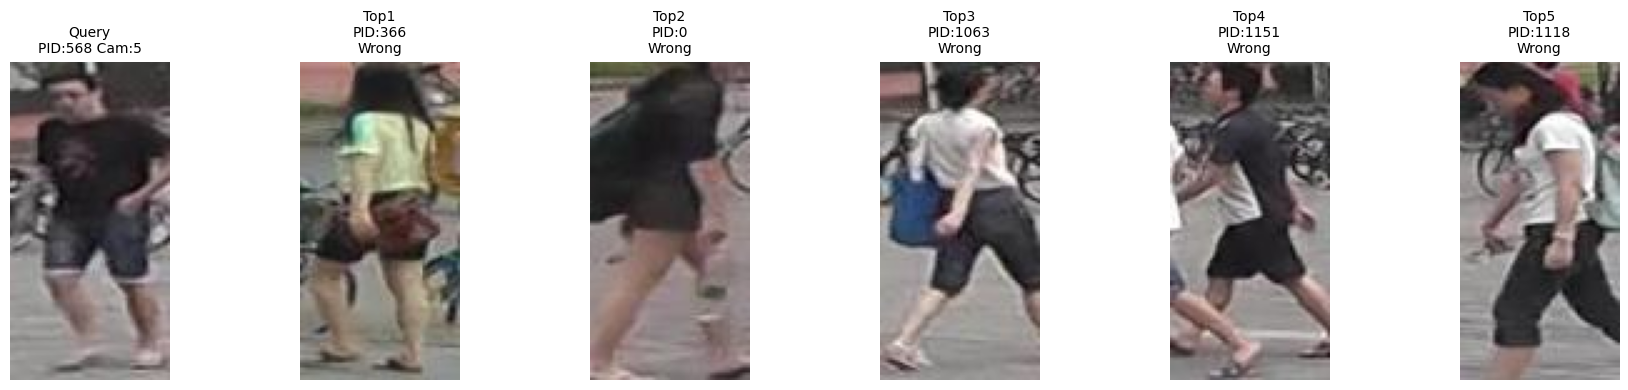

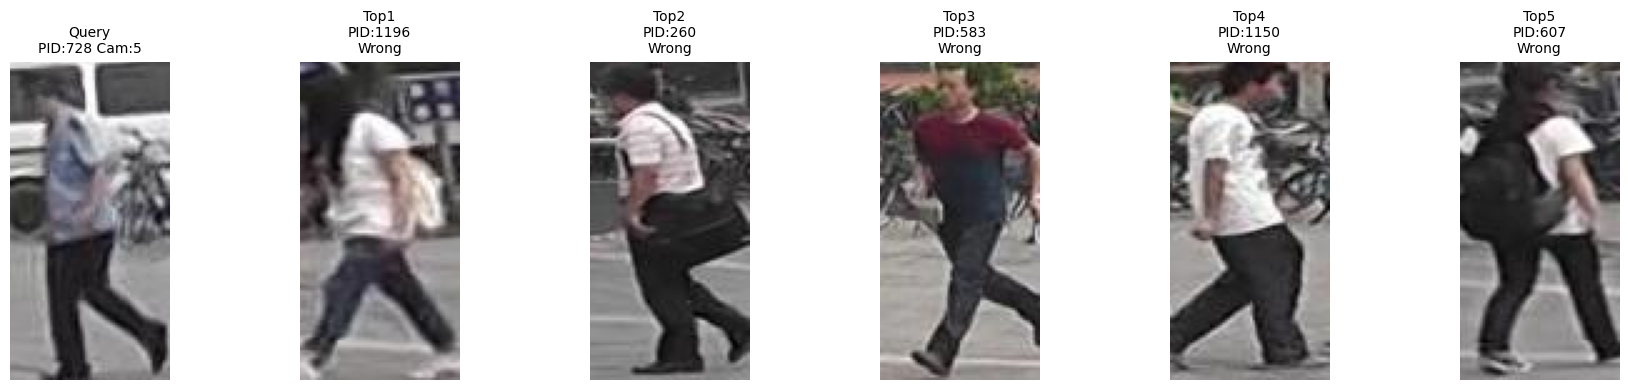

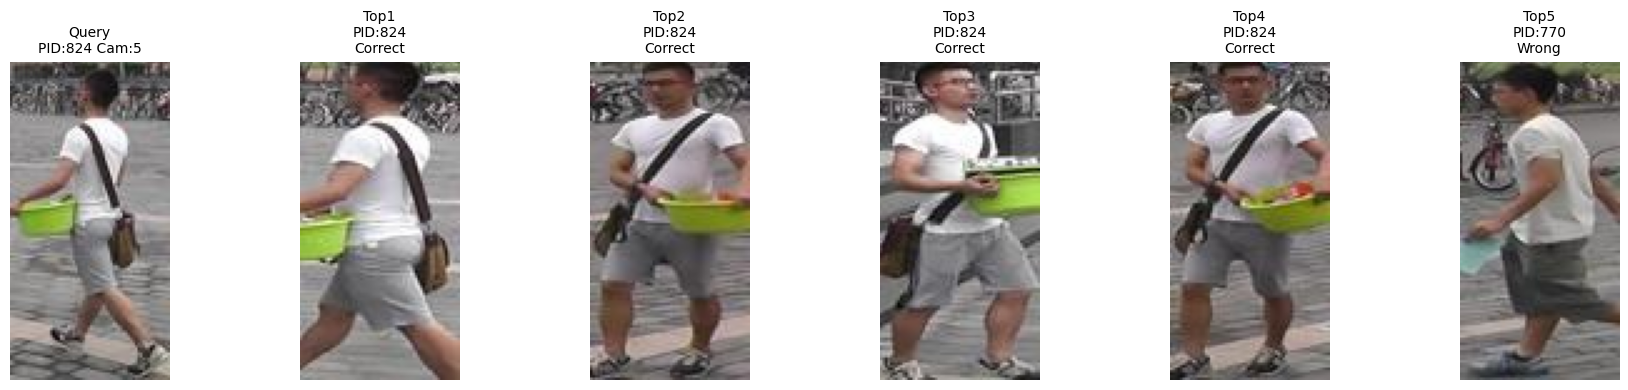

In [1]:
import os
import random
from typing import List, Tuple, Dict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


# =========================================================
# 0. Repro, Device
# =========================================================
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


# =========================================================
# 1. Utilities to parse Market-1501 filename -> (pid, camid)
#    Filename looks like: 0002_c1s1_... .jpg
# =========================================================
def parse_pid_cam(fname: str) -> Tuple[int, int]:
    """Return (pid, camid). pid=-1 means junk."""
    pid_str = fname.split('_')[0]
    try:
        pid = int(pid_str)
    except:
        pid = -1
    # cam code is like 'c1s1', take the '1' after 'c'
    parts = fname.split('_')
    cam_part = parts[1] if len(parts) > 1 else "c-1s-1"
    # find integer directly after 'c'
    camid = -1
    if 'c' in cam_part:
        try:
            camid = int(cam_part.split('c')[1].split('s')[0])
        except:
            camid = -1
    return pid, camid


# =========================================================
# 2. Dataset classes (gallery/query)
# =========================================================
class Market1501Folder(Dataset):
    """
    Reads a flat folder of images (e.g., bounding_box_train, bounding_box_test, query).
    Keeps raw pid/camid (no label remap), as evaluation uses raw IDs.
    """
    def __init__(self, root: str, transform=None):
        self.root = root
        self.transform = transform
        self.samples: List[Tuple[str, int, int]] = []  # (path, pid, camid)

        for fname in os.listdir(root):
            if not fname.lower().endswith('.jpg'):
                continue
            pid, camid = parse_pid_cam(fname)
            if pid == -1:  # junk images
                continue
            self.samples.append((os.path.join(root, fname), pid, camid))

        self.samples.sort(key=lambda x: x[0])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx: int):
        path, pid, camid = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, pid, camid, path


# =========================================================
# 3. Transforms
# =========================================================
transform = transforms.Compose([
    transforms.Resize((256, 128)),  # (H, W) typical for ReID
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])


# =========================================================
# 4. Model (ResNet50 w/ ID head for training; we only need the features for eval)
#    If you already trained, you can load your weights; otherwise we’ll use ImageNet features.
# =========================================================
from torchvision.models import resnet50, ResNet50_Weights

class ReIDModel(nn.Module):
    def __init__(self, embedding_dim=2048):
        super().__init__()
        base = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.feature_extractor = nn.Sequential(*list(base.children())[:-1])  # [B, 2048, 1, 1]
        self.embedding_dim = 2048

    def forward(self, x):
        feat = self.feature_extractor(x)        # [B, 2048, 1, 1]
        feat = feat.view(feat.size(0), -1)      # [B, 2048]
        # Optionally L2-normalize for cosine similarity
        feat = nn.functional.normalize(feat, p=2, dim=1)
        return feat

model = ReIDModel().to(device)
model.eval()
print("Model ready.")


# =========================================================
# 5. Datasets (Gallery + Query)
#    Adjust dataset_root if needed.
# =========================================================
dataset_root = "/kaggle/input/market-1501/Market-1501-v15.09.15"
gallery_dir = os.path.join(dataset_root, "bounding_box_test")
query_dir   = os.path.join(dataset_root, "query")

gallery_set = Market1501Folder(gallery_dir, transform)
query_set   = Market1501Folder(query_dir, transform)

print(f"Gallery images: {len(gallery_set)}")
print(f"Query images:   {len(query_set)}")


# =========================================================
# 6. Feature extraction helper
# =========================================================
@torch.no_grad()
def extract_features(dset: Dataset, batch_size=64) -> Dict[str, torch.Tensor]:
    loader = DataLoader(dset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    all_feats, all_pids, all_camids, all_paths = [], [], [], []
    for imgs, pids, camids, paths in loader:
        imgs = imgs.to(device)
        feats = model(imgs)
        all_feats.append(feats.cpu())
        all_pids.extend(pids.tolist())
        all_camids.extend(camids.tolist())
        all_paths.extend(paths)
    feats = torch.cat(all_feats, dim=0)  # [N, 2048]
    return {
        "feats": feats,                           # [N, D]
        "pids": torch.tensor(all_pids, dtype=torch.long),      # [N]
        "camids": torch.tensor(all_camids, dtype=torch.long),  # [N]
        "paths": all_paths
    }

print("Extracting gallery features...")
gallery = extract_features(gallery_set, batch_size=128)
print("Extracting query features...")
query = extract_features(query_set, batch_size=128)

print("Feature shapes:", gallery["feats"].shape, query["feats"].shape)


# =========================================================
# 7. Similarity + Evaluation (CMC / mAP)
#    - For each query:
#      * compute cosine similarity to gallery
#      * sort by similarity desc
#      * filter out same pid & same cam (as per Market-1501)
#      * compute AP and CMC
# =========================================================
def compute_ap_cmc(
    sim: np.ndarray, gal_pids: np.ndarray, gal_camids: np.ndarray, q_pid: int, q_cam: int
) -> Tuple[float, np.ndarray]:
    """
    Args:
        sim: similarity scores to each gallery item, shape [G]
        gal_pids, gal_camids: gallery pid/cam arrays, shape [G]
        q_pid, q_cam: query pid/cam
    Returns:
        ap: average precision for this query
        cmc: 0/1 array of length G; CMC curve (first correct match rank onward are 1)
    """
    # Sort gallery by similarity desc
    order = np.argsort(-sim)

    # Remove gallery samples with same pid & same cam as the query (per standard Market-1501 protocol)
    mask_junk = (gal_pids == q_pid) & (gal_camids == q_cam)
    # Valid gallery indices after removing junk
    keep = ~mask_junk
    order = order[keep[order]]

    matches = (gal_pids[order] == q_pid).astype(np.int32)  # 1 for correct pid

    # If no valid positives, return (0, zeros)
    num_rel = matches.sum()
    cmc = np.zeros(len(matches), dtype=np.int32)
    if num_rel == 0:
        return 0.0, cmc

    # CMC: find first correct match
    first_idx = np.where(matches == 1)[0][0]
    cmc[first_idx:] = 1

    # mAP: average precision
    # precision at each position where match==1
    idxs = np.where(matches == 1)[0]
    precisions = []
    for i, idx in enumerate(idxs, start=1):
        # number of correct up to idx / (idx + 1)
        prec = matches[:idx+1].sum() / float(idx + 1)
        precisions.append(prec)
    ap = np.mean(precisions)

    return ap, cmc


def evaluate(query, gallery, max_queries: int = None) -> Tuple[float, float]:
    q_feats = query["feats"].numpy()      # [Q, D]
    q_pids  = query["pids"].numpy()
    q_cams  = query["camids"].numpy()

    g_feats = gallery["feats"].numpy()    # [G, D]
    g_pids  = gallery["pids"].numpy()
    g_cams  = gallery["camids"].numpy()

    # cosine similarity since features are L2-normalized: sim = q @ g.T
    sims = np.dot(q_feats, g_feats.T)  # [Q, G]

    aps = []
    cmc_accum = None

    Q = len(q_feats) if max_queries is None else min(max_queries, len(q_feats))
    for i in range(Q):
        ap, cmc = compute_ap_cmc(sims[i], g_pids, g_cams, q_pids[i], q_cams[i])
        aps.append(ap)
        if cmc_accum is None:
            cmc_accum = cmc.astype(np.float64)
        else:
            # Align lengths (cmc length equals number of kept gallery after filtering; use full gallery length upper bound)
            L = max(len(cmc_accum), len(cmc))
            if len(cmc_accum) < L:
                cmc_accum = np.pad(cmc_accum, (0, L - len(cmc_accum)))
            if len(cmc) < L:
                cmc = np.pad(cmc, (0, L - len(cmc)))
            cmc_accum += cmc

    mAP = float(np.mean(aps) if aps else 0.0)
    # Rank-1 is CMC[0] averaged over queries
    rank1 = float(cmc_accum[0] / Q if cmc_accum is not None else 0.0)

    return mAP, rank1


# ---- Evaluate on a small subset for speed (change to None for full) ----
mAP_small, rank1_small = evaluate(query, gallery, max_queries=100)  # e.g., first 100 queries
print(f"[Subset Eval] Q=100 → mAP: {mAP_small:.4f}, Rank-1: {rank1_small:.4f}")

# (Optional) Full evaluation (may take longer):
# mAP_full, rank1_full = evaluate(query, gallery, max_queries=None)
# print(f"[Full Eval] mAP: {mAP_full:.4f}, Rank-1: {rank1_full:.4f}")


# =========================================================
# 8. Visualization: show Top-K retrievals for a few queries
# =========================================================
def visualize_topk(
    query, gallery, k: int = 5, num_queries: int = 3, random_pick: bool = True
):
    q_feats = query["feats"].numpy()
    q_pids  = query["pids"].numpy()
    q_cams  = query["camids"].numpy()
    q_paths = query["paths"]

    g_feats = gallery["feats"].numpy()
    g_pids  = gallery["pids"].numpy()
    g_cams  = gallery["camids"].numpy()
    g_paths = gallery["paths"]

    sims = np.dot(q_feats, g_feats.T)  # cosine similarity

    Q_idx_list = list(range(len(q_feats)))
    if random_pick:
        random.shuffle(Q_idx_list)
    Q_idx_list = Q_idx_list[:num_queries]

    for qi in Q_idx_list:
        q_pid, q_cam, q_path = q_pids[qi], q_cams[qi], q_paths[qi]

        # sort by similarity desc
        order = np.argsort(-sims[qi])
        # filter junk (same pid & same cam as query)
        junk = (g_pids == q_pid) & (g_cams == q_cam)
        keep_order = order[~junk[order]]

        topk = keep_order[:k]
        topk_paths = [g_paths[i] for i in topk]
        topk_pids  = g_pids[topk]

        # Plot
        plt.figure(figsize=(3*(k+1), 4))

        # Query image
        ax = plt.subplot(1, k+1, 1)
        ax.imshow(Image.open(q_path).convert("RGB"))
        ax.set_title(f"Query\nPID:{q_pid} Cam:{q_cam}", fontsize=10)
        ax.axis("off")

        # Top-K gallery results
        for j, (p, pid) in enumerate(zip(topk_paths, topk_pids), start=2):
            ax = plt.subplot(1, k+1, j)
            ax.imshow(Image.open(p).convert("RGB"))
            match = (pid == q_pid)
            ax.set_title(f"Top{j-1}\nPID:{pid}\n{'Correct' if match else 'Wrong'}", fontsize=10)
            # Optional: a thin border to indicate correct/incorrect
            for spine in ax.spines.values():
                spine.set_linewidth(3.0)
                spine.set_edgecolor("green" if match else "red")
            ax.axis("off")

        plt.tight_layout()
        plt.show()

# Show three random queries with their Top-5 retrievals
visualize_topk(query, gallery, k=5, num_queries=3, random_pick=True)
